# **Bagian 1: Import Library dan Data Eksplorasi**

In [32]:
# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Untuk preprocessing & modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [34]:
# Untuk visualisasi interaktif (nanti saat Streamlit)
import streamlit as st

# Menampilkan semua kolom jika dibutuhkan
pd.set_option('display.max_columns', None)

# Baca file CSV
df = pd.read_csv("PhabletSmartphoneSemarang2024-new-backup.csv")  # Ganti nama jika perlu

# Tampilkan 5 baris pertama
print("Contoh data awal:")
display(df.head())

# Info struktur data
print("\nInformasi struktur data:")
df.info()

# Statistik deskriptif untuk kolom numerik
print("\nStatistik deskriptif:")
display(df.describe())

# Cek jumlah nilai null per kolom
print("\nJumlah missing value per kolom:")
display(df.isnull().sum())

# Cek jumlah duplikasi data
print("\nJumlah data duplikat:")
print(df.duplicated().sum())


Contoh data awal:


,PERIOD Code,PERIOD Detail,SHOPNAME,PRODUCT,BRAND,MODEL,SALES,PRICE,CHANNELNAME,SHOPSIZE1,REGION,CITY
0,2403M,Maret 2024,17 PHONE,PHABLETS,APPLE,IPHONE 13 128/4GB SIM/ESIM NFC 5G,1,10000000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA"
1,2403M,Maret 2024,17 PHONE,PHABLETS,APPLE,IPHONE 15 PRO 256/8GB SIM/ESIM NFC 5G,1,21999000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA"
2,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,HOT 30 128/8GB X6831 DUAL NFC LTE,3,1699000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA"
3,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,HOT 30I 128/8GB X669D DUAL NFC LTE,3,1700000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA"
4,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,NOTE 30 256/8GB X6833B DUAL NFC LTE,3,2450000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA"



Informasi struktur data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14224 entries, 0 to 14223
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PERIOD  Code    14224 non-null  object
 1   PERIOD  Detail  14224 non-null  object
 2   SHOPNAME        14224 non-null  object
 3   PRODUCT         14224 non-null  object
 4   BRAND           14224 non-null  object
 5   MODEL           14224 non-null  object
 6   SALES           14224 non-null  int64 
 7   PRICE           14224 non-null  object
 8   CHANNELNAME     14224 non-null  object
 9   SHOPSIZE1       14224 non-null  object
 10  REGION          14224 non-null  object
 11  CITY            14224 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.3+ MB

Statistik deskriptif:


,SALES
count,14224.000000
mean,7.008999
std,16.531381
min,1.000000
25%,2.000000
50%,3.000000
75%,8.000000
max,737.000000



Jumlah missing value per kolom:


PERIOD  Code      0
PERIOD  Detail    0
SHOPNAME          0
PRODUCT           0
BRAND             0
MODEL             0
SALES             0
PRICE             0
CHANNELNAME       0
SHOPSIZE1         0
REGION            0
CITY              0
dtype: int64


Jumlah data duplikat:
0


# **Bagian 2: Data Cleansing**

In [35]:
# 1. Menghapus data duplikat
print("Jumlah data sebelum menghapus duplikat:", len(df))
df = df.drop_duplicates()
print("Jumlah data setelah menghapus duplikat:", len(df))

# 2. Cek ulang missing value
print("\nMissing value per kolom (setelah drop duplicate):")
display(df.isnull().sum())

# 3. Menangani missing value (jika ada)
# Catatan: Jika kolom kategorikal → Imputasi dengan modus, jika numerik → imputasi dengan median
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Imputer untuk masing-masing tipe kolom
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

df[categorical_cols] = pd.DataFrame(cat_imputer.fit_transform(df[categorical_cols]), columns=categorical_cols)
df[numerical_cols] = pd.DataFrame(num_imputer.fit_transform(df[numerical_cols]), columns=numerical_cols)

# Cek ulang missing value
print("\nMissing value setelah imputasi:")
display(df.isnull().sum())


Jumlah data sebelum menghapus duplikat: 14224
Jumlah data setelah menghapus duplikat: 14224

Missing value per kolom (setelah drop duplicate):


PERIOD  Code      0
PERIOD  Detail    0
SHOPNAME          0
PRODUCT           0
BRAND             0
MODEL             0
SALES             0
PRICE             0
CHANNELNAME       0
SHOPSIZE1         0
REGION            0
CITY              0
dtype: int64


Missing value setelah imputasi:


PERIOD  Code      0
PERIOD  Detail    0
SHOPNAME          0
PRODUCT           0
BRAND             0
MODEL             0
SALES             0
PRICE             0
CHANNELNAME       0
SHOPSIZE1         0
REGION            0
CITY              0
dtype: int64

# **Bagian 3: Data Transformation, Feature Engineering & PCA**

In [36]:
## 1. Ekstraksi Fitur RAM dan ROM dari MODEL
import re
def extract_ram(model):
    match = re.search(r"(\d+)GB", model)
    return int(match.group(1)) if match else None

def extract_rom(model):
    match = re.search(r"(\d+)/", model)
    return int(match.group(1)) if match else None

df['RAM'] = df['MODEL'].apply(lambda x: extract_ram(str(x)))
df['ROM'] = df['MODEL'].apply(lambda x: extract_rom(str(x)))


# Tangani missing value hasil ekstraksi (jika ada)
df[['ROM', 'RAM']] = df[['ROM', 'RAM']].fillna(0)


In [37]:
df.head()

,PERIOD Code,PERIOD Detail,SHOPNAME,PRODUCT,BRAND,MODEL,SALES,PRICE,CHANNELNAME,SHOPSIZE1,REGION,CITY,RAM,ROM
0,2403M,Maret 2024,17 PHONE,PHABLETS,APPLE,IPHONE 13 128/4GB SIM/ESIM NFC 5G,1.0,10000000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",4.0,128.0
1,2403M,Maret 2024,17 PHONE,PHABLETS,APPLE,IPHONE 15 PRO 256/8GB SIM/ESIM NFC 5G,1.0,21999000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,256.0
2,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,HOT 30 128/8GB X6831 DUAL NFC LTE,3.0,1699000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,128.0
3,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,HOT 30I 128/8GB X669D DUAL NFC LTE,3.0,1700000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,128.0
4,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,NOTE 30 256/8GB X6833B DUAL NFC LTE,3.0,2450000,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,256.0


In [38]:

# 2. One-Hot Encoding untuk kolom kategorikal (selain target)
categorical_features = ['BRAND', 'CHANNELNAME']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 3. Sampling Data (optional — jika terlalu besar, kita sampling 5000 row)
if len(df_encoded) > 14224:
    sampled_idx = df_encoded.sample(n=14224, random_state=42).index
    df_encoded = df_encoded.loc[sampled_idx]
    df_sample = df.loc[sampled_idx].copy()
else:
    df_sample = df.copy()



In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# 4. Bersihkan dan konversi kolom PRICE menjadi numerik
df['PRICE'] = df['PRICE'].astype(str).str.replace(',', '', regex=True).str.replace(' ', '', regex=True)
df['PRICE'] = df['PRICE'].replace('-', np.nan)
df['PRICE'] = pd.to_numeric(df['PRICE'], errors='coerce')
df['PRICE'] = df['PRICE'].fillna(df['PRICE'].median())

# Bersihkan dan konversi kolom SALES menjadi numerik
df['SALES'] = df['SALES'].astype(str).str.replace(',', '', regex=True).str.replace(' ', '', regex=True)
df['SALES'] = df['SALES'].replace('-', np.nan)
df['SALES'] = pd.to_numeric(df['SALES'], errors='coerce')
df['SALES'] = df['SALES'].fillna(df['SALES'].median())

# Copy hasil bersih ke df_encoded (pastikan df_encoded sudah berisi data encoded sebelumnya)
df_encoded['PRICE'] = df['PRICE'].values
df_encoded['SALES'] = df['SALES'].values

# List kolom numerik yang akan distandarisasi
numeric_cols = ['PRICE', 'SALES', 'ROM', 'RAM']

# Standarisasi fitur numerik
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

In [40]:
df_encoded.head()

,PERIOD Code,PERIOD Detail,SHOPNAME,PRODUCT,MODEL,SALES,PRICE,SHOPSIZE1,REGION,CITY,RAM,ROM,BRAND_EVERCOSS/CROSS,BRAND_INFINIX,BRAND_IQOO,BRAND_ITEL,BRAND_LUNA,BRAND_NUBIA,BRAND_OPPO,BRAND_POCO,BRAND_REALME,BRAND_REDMI,BRAND_SAMSUNG,BRAND_TECNO,BRAND_VIVO,BRAND_XIAOMI,BRAND_ZTE
0,2403M,Maret 2024,17 PHONE,PHABLETS,IPHONE 13 128/4GB SIM/ESIM NFC 5G,-0.363503,1.399395,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",-1.269124,-0.628295,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2403M,Maret 2024,17 PHONE,PHABLETS,IPHONE 15 PRO 256/8GB SIM/ESIM NFC 5G,-0.363503,4.201407,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",0.354880,0.590923,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2403M,Maret 2024,17 PHONE,PHABLETS,HOT 30 128/8GB X6831 DUAL NFC LTE,-0.242517,-0.539058,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",0.354880,-0.628295,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2403M,Maret 2024,17 PHONE,PHABLETS,HOT 30I 128/8GB X669D DUAL NFC LTE,-0.242517,-0.538825,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",0.354880,-0.628295,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2403M,Maret 2024,17 PHONE,PHABLETS,NOTE 30 256/8GB X6833B DUAL NFC LTE,-0.242517,-0.363684,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",0.354880,0.590923,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [41]:
# 5. PCA untuk reduksi dimensi (2 komponen utama)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_encoded[numeric_cols])

# Tambahkan hasil PCA ke df_encoded
df_encoded['PCA1'] = pca_features[:, 0]
df_encoded['PCA2'] = pca_features[:, 1]

# Tampilkan hasil PCA dan proporsi varians yang dijelaskan
print("\nHasil reduksi dimensi PCA (5 data pertama):")
print(df_encoded[['PCA1', 'PCA2']].head())

print("\nExplained variance ratio oleh dua komponen PCA:")
print(pca.explained_variance_ratio_)



Hasil reduksi dimensi PCA (5 data pertama):
       PCA1      PCA2
0 -0.404339 -0.385060
1  2.713823  0.035742
2 -0.406004 -0.314832
3 -0.405888 -0.314814
4  0.424393 -0.195257

Explained variance ratio oleh dua komponen PCA:
[0.54414307 0.24507122]


# **Bagian 4 : Pre-Modeling — Label Encoding & Split Dataset** 

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. Salin kolom SHOPSIZE1 sebagai kolom target di df_encoded
df_encoded['SHOPSIZE'] = df['SHOPSIZE1'].values  # pastikan index sinkron

# 2. Label Encoding untuk kolom SHOPSIZE (target klasifikasi)
label_encoder = LabelEncoder()
df_encoded['SHOPSIZE_ENC'] = label_encoder.fit_transform(df_encoded['SHOPSIZE'])

# Tampilkan mapping label untuk interpretasi
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping SHOPSIZE ke label numerik:", label_mapping)

# 3. Tentukan fitur dan target
# Hapus kolom yang tidak diperlukan sebagai fitur (termasuk target dan kolom non-fitur)
cols_to_drop = [
    'SHOPSIZE', 'SHOPSIZE_ENC', 'PCA1', 'PCA2',
    'SHOPSIZE1', 'MODEL', 'SHOPNAME',
    'PERIOD  Detail', 'PERIOD  Code', 'PRODUCT', 'REGION', 'CITY'
]

X = df_encoded.drop(columns=cols_to_drop, errors='ignore')
y = df_encoded['SHOPSIZE_ENC']

# 4. Split dataset menjadi training dan testing dengan stratifikasi untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Tampilkan jumlah data train dan test
print("\nJumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

# 6. Opsional: cek distribusi kelas
print("\nDistribusi kelas di train:")
print(y_train.value_counts(normalize=True))

print("\nDistribusi kelas di test:")
print(y_test.value_counts(normalize=True))


Mapping SHOPSIZE ke label numerik: {'LARGE': 0, 'MEDIUM': 1, 'SMALL': 2, 'XLARGE': 3}

Jumlah data train: 11379
Jumlah data test: 2845

Distribusi kelas di train:
SHOPSIZE_ENC
1    0.359434
0    0.291062
3    0.244925
2    0.104579
Name: proportion, dtype: float64

Distribusi kelas di test:
SHOPSIZE_ENC
1    0.359578
0    0.291037
3    0.244991
2    0.104394
Name: proportion, dtype: float64


# **Bagian 5: Tahapan Agregasi Fitur Per Toko hingga Persiapan Dataset**

In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Misal df adalah dataset produk per toko yang sudah bersih dan fitur RAM_GB & ROM_GB sudah diekstrak

# 1. Agregasi fitur numerik per toko
agg_numerical = df.groupby('SHOPNAME').agg({
    'PRICE': 'mean',      # rata-rata harga produk yang terjual di toko
    'SALES': 'sum',       # total unit terjual di toko
    'RAM': 'mean',     # rata-rata RAM produk di toko
    'ROM': 'mean'      # rata-rata ROM produk di toko
})

# 2. Hitung jumlah model unik per toko
agg_numerical['jumlah_model'] = df.groupby('SHOPNAME')['MODEL'].nunique()

# 3. Hitung distribusi jumlah produk per BRAND di tiap toko (one-hot encoding brand)
brand_counts = pd.crosstab(df['SHOPNAME'], df['BRAND'])

# 4. Gabungkan semua fitur menjadi satu DataFrame tingkat toko
df_toko = agg_numerical.join(brand_counts)

# 5. Ambil label target SHOPSIZE per toko (diasumsikan seragam per toko)
toko_size = df.groupby('SHOPNAME')['SHOPSIZE1'].first()
df_toko['SHOPSIZE'] = toko_size

# Drop toko tanpa label SHOPSIZE jika ada
df_toko = df_toko.dropna(subset=['SHOPSIZE'])

# 6. Label encoding untuk target SHOPSIZE
label_encoder = LabelEncoder()
df_toko['SHOPSIZE_ENC'] = label_encoder.fit_transform(df_toko['SHOPSIZE'])

print("Mapping SHOPSIZE ke label numerik:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# 7. Siapkan fitur (X) dan target (y)
X = df_toko.drop(columns=['SHOPSIZE', 'SHOPSIZE_ENC'])
y = df_toko['SHOPSIZE_ENC']

# 8. Standarisasi fitur numerik (hanya fitur numerik: PRICE, SALES, RAM, ROM, jumlah_model)
numerical_features = ['PRICE', 'SALES', 'RAM', 'ROM', 'jumlah_model']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# 9. Split dataset menjadi training dan test set dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test: {len(X_test)}")


Mapping SHOPSIZE ke label numerik: {'LARGE': 0, 'MEDIUM': 1, 'SMALL': 2, 'XLARGE': 3}
Jumlah data train: 36
Jumlah data test: 9


# **BAB 6: Tahapan Training dan Evaluasi Model Logistic Regression**

In [44]:
# 10. Inisialisasi dan train model Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 11. Prediksi pada data test
y_pred = model.predict(X_train)

# 12. Evaluasi performa model
accuracy = accuracy_score(y_train, y_pred)
print(f"Akurasi model pada data test: {accuracy:.4f}")

print("\nLaporan klasirainasi:")
print(classification_report(y_train, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

Akurasi model pada data test: 0.9722

Laporan klasirainasi:
              precision    recall  f1-score   support

       LARGE       1.00      0.83      0.91         6
      MEDIUM       0.92      1.00      0.96        11
       SMALL       1.00      1.00      1.00        14
      XLARGE       1.00      1.00      1.00         5

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36

Confusion Matrix:
[[ 5  1  0  0]
 [ 0 11  0  0]
 [ 0  0 14  0]
 [ 0  0  0  5]]


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


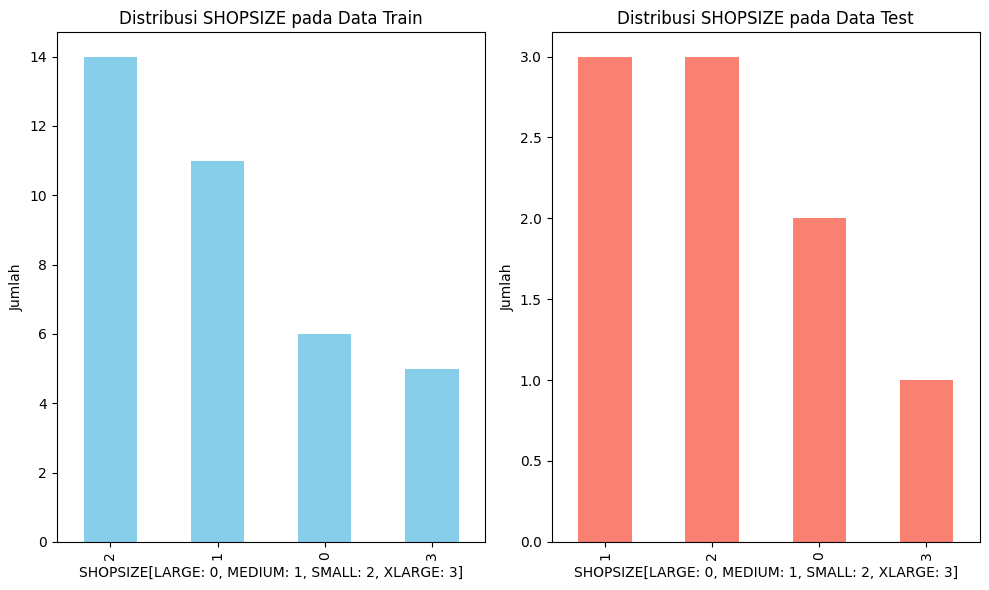

In [45]:
import matplotlib.pyplot as plt

# Visualisasi distribusi kelas pada data latih dan uji
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribusi SHOPSIZE pada Data Train')
plt.xlabel('SHOPSIZE[LARGE: 0, MEDIUM: 1, SMALL: 2, XLARGE: 3]')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', color='salmon')
plt.title('Distribusi SHOPSIZE pada Data Test')
plt.xlabel('SHOPSIZE[LARGE: 0, MEDIUM: 1, SMALL: 2, XLARGE: 3]')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()


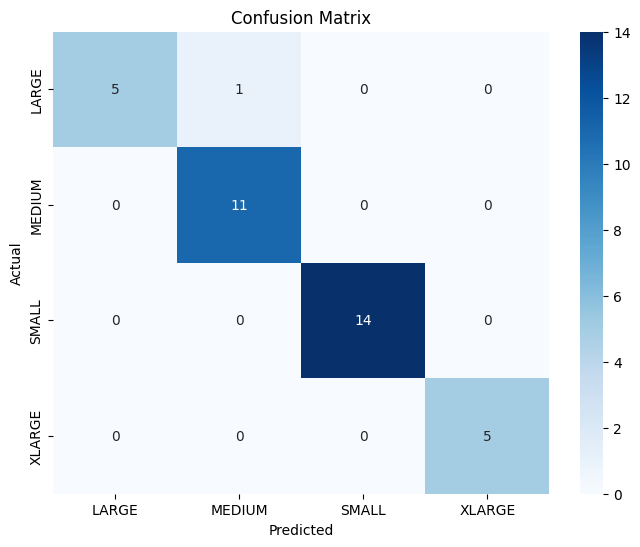

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Visualisasikan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


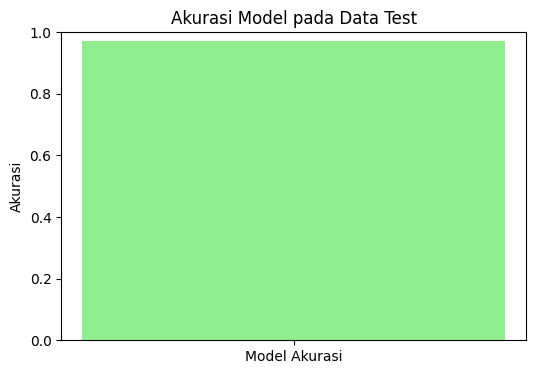

In [47]:
# Visualisasi akurasi
plt.figure(figsize=(6, 4))
plt.bar(['Model Akurasi'], [accuracy], color='lightgreen')
plt.ylabel('Akurasi')
plt.title('Akurasi Model pada Data Test')
plt.ylim(0, 1)
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15504\3705759848.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


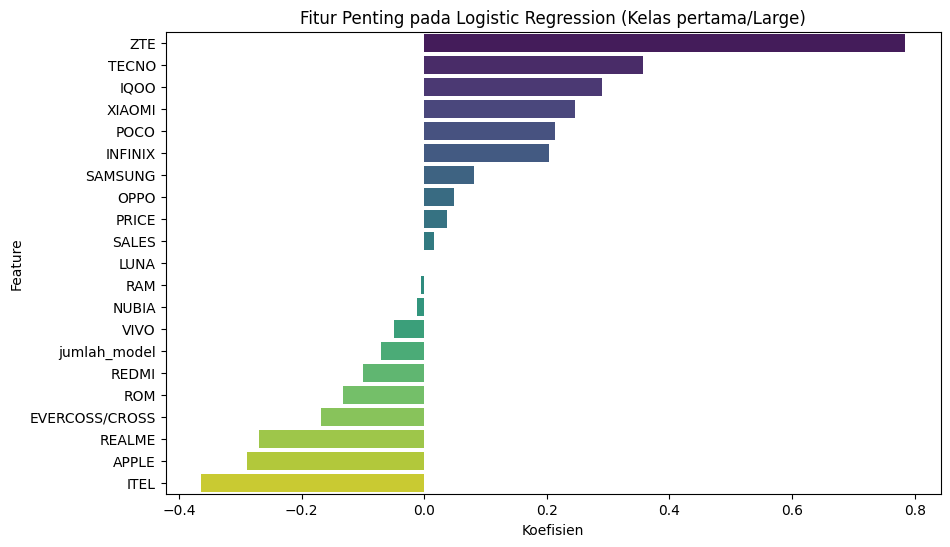

In [48]:
coefficients = model.coef_[0]  # koefisien untuk kelas pertama
features = X.columns

feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Fitur Penting pada Logistic Regression (Kelas pertama/Large)')
plt.xlabel('Koefisien')
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15504\3583359943.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


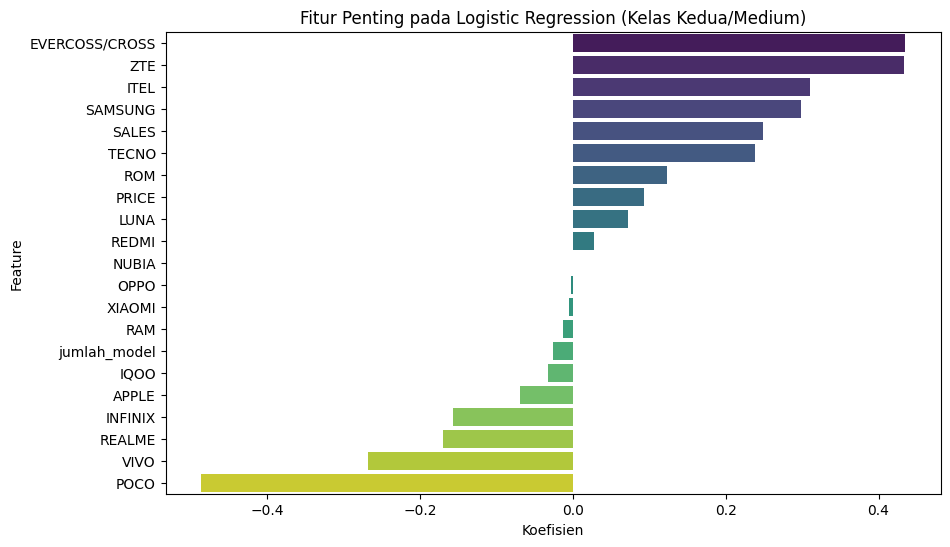

In [49]:
coefficients = model.coef_[1]  # koefisien untuk kelas pertama
features = X.columns

feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Fitur Penting pada Logistic Regression (Kelas Kedua/Medium)')
plt.xlabel('Koefisien')
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15504\3453076015.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


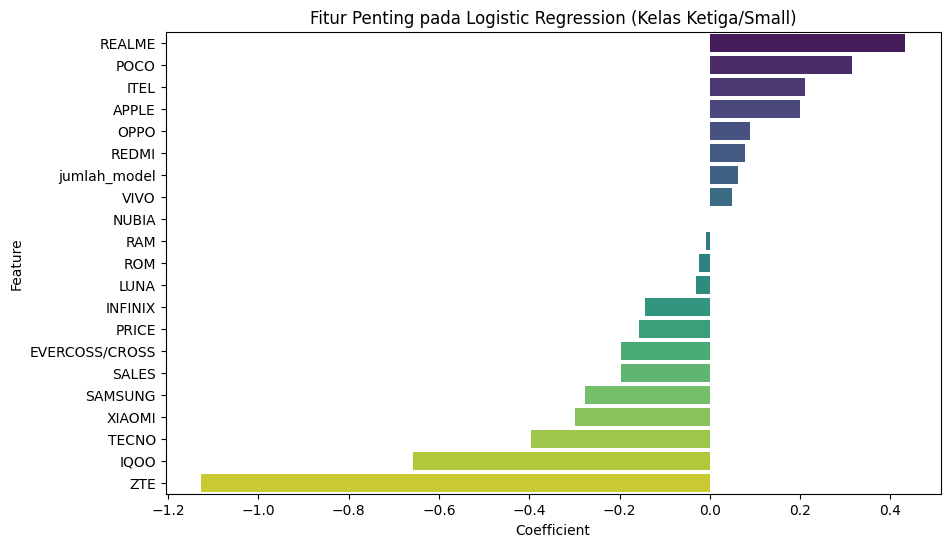

In [50]:
coefficients = model.coef_[2]  # koefisien untuk kelas pertama
features = X.columns

feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Fitur Penting pada Logistic Regression (Kelas Ketiga/Small)')
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15504\39491162.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


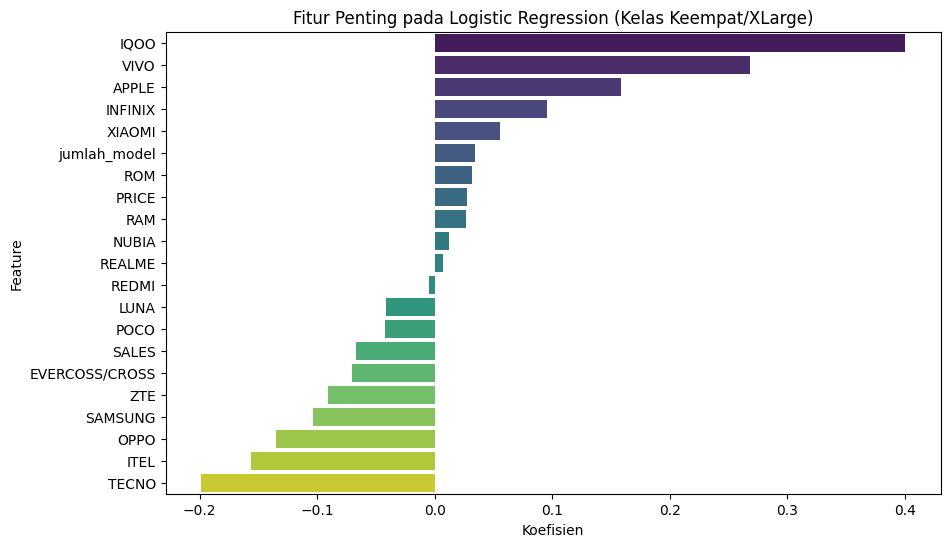

In [51]:
coefficients = model.coef_[3]  # koefisien untuk kelas pertama
features = X.columns

feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Fitur Penting pada Logistic Regression (Kelas Keempat/XLarge)')
plt.xlabel('Koefisien')
plt.show()


# **Bagian 7: Model Tuning Logistic Regression dengan GridSearchCV**

Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.45
Test accuracy: 0.2222222222222222


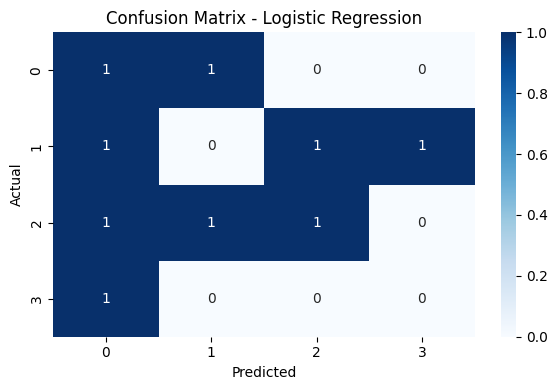

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # solver yang support l1 dan l2
    'max_iter': [1000]
}

logreg = LogisticRegression(class_weight='balanced', random_state=42)
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

# **Bagian 8: Bagian K-Means Clustering: Elbow Method**

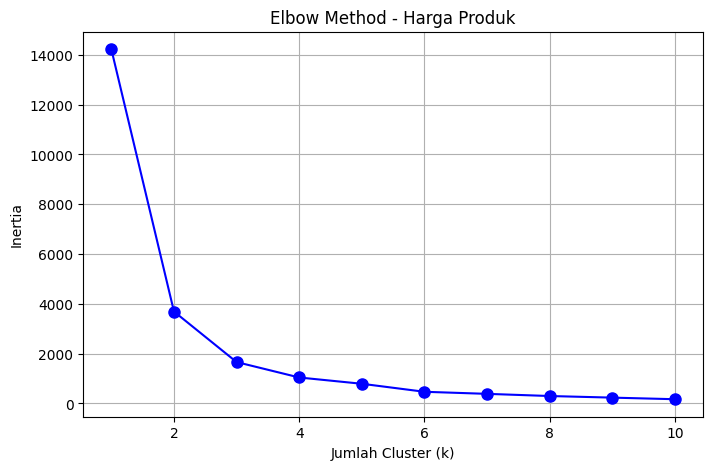

,PERIOD Code,PERIOD Detail,SHOPNAME,PRODUCT,BRAND,MODEL,SALES,PRICE,CHANNELNAME,SHOPSIZE1,REGION,CITY,RAM,ROM,cluster_label,segment
0,2403M,Maret 2024,17 PHONE,PHABLETS,APPLE,IPHONE 13 128/4GB SIM/ESIM NFC 5G,1.0,10000000.0,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",4.0,128.0,2,Mid-Range
1,2403M,Maret 2024,17 PHONE,PHABLETS,APPLE,IPHONE 15 PRO 256/8GB SIM/ESIM NFC 5G,1.0,21999000.0,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,256.0,1,Flagship
2,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,HOT 30 128/8GB X6831 DUAL NFC LTE,3.0,1699000.0,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,128.0,0,Entry Level
3,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,HOT 30I 128/8GB X669D DUAL NFC LTE,3.0,1700000.0,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,128.0,0,Entry Level
4,2403M,Maret 2024,17 PHONE,PHABLETS,INFINIX,NOTE 30 256/8GB X6833B DUAL NFC LTE,3.0,2450000.0,Mobile Phone Specialists,LARGE,CENTRAL JAVA,"SEMARANG, KOTA",8.0,256.0,0,Entry Level


In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ambil kolom PRICE dari df
X = df[['PRICE']].copy()

# Bersihkan kolom PRICE (ubah ke numerik dan isi missing)
X['PRICE'] = X['PRICE'].astype(str).str.replace(',', '', regex=True).str.replace(' ', '', regex=True)
X['PRICE'] = pd.to_numeric(X['PRICE'], errors='coerce')
X['PRICE'] = X['PRICE'].fillna(X['PRICE'].median())

# Standarisasi kolom PRICE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method untuk menentukan jumlah cluster optimal
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Harga Produk')
plt.grid(True)
plt.show()

# Pilih jumlah cluster (misal 3)
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

# Simpan hasil cluster di df
df['cluster_label'] = clusters

# Mapping cluster ke segmen sesuai keinginan
cluster_to_segment = {
    0: 'Entry Level',
    1: 'Flagship',
    2: 'Mid-Range'
}

df['segment'] = df['cluster_label'].map(cluster_to_segment)

# Tampilkan data sample dengan cluster
df.head()


In [54]:
# 1. Analisis statistik harga per cluster
price_stats = df.groupby('segment')['PRICE'].describe()
print("Statistik Harga per Cluster:")
print(price_stats)

Statistik Harga per Cluster:
               count          mean           std         min         25%  \
segment                                                                    
Entry Level  10641.0  2.241749e+06  8.436679e+05    323000.0   1500000.0   
Flagship       772.0  1.926520e+07  4.003597e+06  12999000.0  15999000.0   
Mid-Range     2811.0  6.500904e+06  1.936167e+06   4399000.0   4999000.0   

                    50%         75%         max  
segment                                          
Entry Level   2000000.0   2799000.0   4350000.0  
Flagship     18999000.0  21999000.0  31999000.0  
Mid-Range     5999000.0   7000000.0  12850000.0  


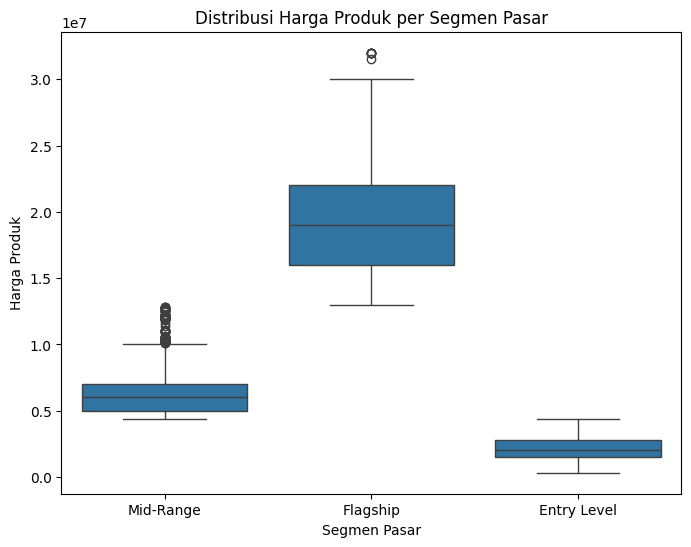

In [55]:
# 2. Visualisasi boxplot distribusi harga per segmen
plt.figure(figsize=(8, 6))
sns.boxplot(x='segment', y='PRICE', data=df)
plt.title('Distribusi Harga Produk per Segmen Pasar')
plt.xlabel('Segmen Pasar')
plt.ylabel('Harga Produk')
plt.show()


In [56]:
# df_toko.to_csv("dataDashboardTokoAggregated.csv", index=False)


# **BAB 8: Deployment**

In [57]:
!ngrok config add-authtoken 2wwQ4ccDVn8DGyvtLH6XNzO9YRJ_7oaH4LCxsyr7DTPz2oFSS

Authtoken saved to configuration file: C:\Users\Asus\AppData\Local/ngrok/ngrok.yml


In [58]:
# pip install streamlit

In [59]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

st.set_page_config(layout="wide")
st.title("📊 Dashboard Analisis Harga Handphone & Segmentasi Pasar (Semarang)")

# ======================================
# LOAD DATA
# Pastikan file CSV sudah disiapkan dengan benar
# ======================================
df_produk = pd.read_csv("dataDashboardPhabletSample.csv")  # Data produk level
df_toko = pd.read_csv("dataDashboardTokoAggregated.csv")   # Data toko level
unique_shopnames = df_produk['SHOPNAME'].drop_duplicates().reset_index(drop=True)
df_toko['SHOPNAME'] = unique_shopnames

# Pastikan kolom 'segment' ada di df_produk (hasil mapping cluster)
if 'segment' not in df_produk.columns and 'cluster_label' in df_produk.columns:
    cluster_to_segment = {
        0: 'Entry Level',
        1: 'Mid-Range',
        2: 'Flagship'
    }
    df_produk['segment'] = df_produk['cluster_label'].map(cluster_to_segment)

# Pastikan kolom 'SHOPSIZE_PRED' (hasil prediksi Logistic Regression) ada di df_toko
if 'SHOPSIZE_PRED' not in df_toko.columns and 'SHOPSIZE_ENC_PRED' in df_toko.columns:
    # Map label numerik ke nama kategori toko (sesuaikan dengan mapping kamu)
    label_map_toko = {
        0: 'LARGE',
        1: 'MEDIUM',
        2: 'SMALL',
        3: 'XLARGE'
    }
    df_toko['SHOPSIZE_PRED'] = df_toko['SHOPSIZE_ENC_PRED'].map(label_map_toko)

# ======================================
# Sidebar: Pilih View Dashboard
# ======================================
view_option = st.sidebar.selectbox("Pilih Tampilan Dashboard", ["Produk (Segmentasi Pasar)", "Toko (Prediksi Kategori)"])

# ========================
# DASHBOARD PRODUK
# ========================
if view_option == "Produk (Segmentasi Pasar)":
    st.header("📦 Dashboard Produk - Segmentasi Pasar")
    # Filter Brand
    brands = df_produk['BRAND'].unique().tolist()
    brands.sort()
    brands.insert(0, "Semua")
    selected_brand = st.sidebar.selectbox("Filter Merek", brands)

    # Filter Segmen
    segments = df_produk['segment'].unique().tolist()
    segments.sort()
    segments.insert(0, "Semua")
    selected_segment = st.sidebar.selectbox("Filter Segmen Pasar", segments)

    # Filter data
    df_filtered = df_produk.copy()
    if selected_brand != "Semua":
        df_filtered = df_filtered[df_filtered['BRAND'] == selected_brand]
    if selected_segment != "Semua":
        df_filtered = df_filtered[df_filtered['segment'] == selected_segment]

    # Tampilkan data terfilter
    st.subheader(f"Data Produk (Merek: {selected_brand}, Segmen: {selected_segment})")
    st.dataframe(df_filtered[['PRODUCT', 'SHOPNAME', 'BRAND','MODEL', 'PRICE', 'RAM', 'ROM', 'segment']].head(14224))

    # Visualisasi boxplot harga per segmen
    st.subheader("Distribusi Harga per Segmen Pasar")
    fig1, ax1 = plt.subplots(figsize=(8,4))
    sns.boxplot(data=df_filtered, x='segment', y='PRICE', palette='pastel', ax=ax1)
    ax1.set_xlabel("Segmen Pasar")
    ax1.set_ylabel("Harga (PRICE)")
    st.pyplot(fig1)

    # Visualisasi sebaran RAM vs ROM berdasarkan segmen
    st.subheader("Sebaran Produk berdasarkan RAM dan ROM dengan Segmen")
    fig2, ax2 = plt.subplots(figsize=(8,5))
    sns.scatterplot(data=df_filtered, x='RAM', y='ROM', hue='segment', palette='Set2', ax=ax2)
    ax2.set_xlabel("RAM (GB)")
    ax2.set_ylabel("ROM (GB)")
    ax2.set_title("Sebaran Produk berdasarkan RAM, ROM & Segmen Pasar")
    st.pyplot(fig2)

    # Ringkasan statistik harga dan spesifikasi per segmen
    st.subheader("Rangkuman Statistik per Segmen Pasar")
    summary_segmen = df_produk.groupby('segment').agg({
        'PRICE': ['mean', 'min', 'max', 'median'],
        'RAM': ['mean', 'min', 'max'],
        'ROM': ['mean', 'min', 'max']
    }).round(2)
    st.dataframe(summary_segmen)

# ========================
# DASHBOARD TOKO
# ========================
elif view_option == "Toko (Prediksi Kategori)":
    st.header("🏬 Dashboard Toko - Prediksi Kategori Toko")

    # Filter kategori toko
    toko_categories = df_toko['SHOPSIZE'].unique().tolist()
    toko_categories.sort()
    toko_categories.insert(0, "Semua")
    selected_kategori = st.sidebar.selectbox("Filter Kategori Toko", toko_categories)

    df_toko_filtered = df_toko.copy()
    if selected_kategori != "Semua":
        df_toko_filtered = df_toko_filtered[df_toko_filtered['SHOPSIZE'] == selected_kategori]

    # Tampilkan data toko
    st.subheader(f"Data Toko - Kategori: {selected_kategori}")
    st.dataframe(df_toko_filtered[[ 'SHOPNAME','SHOPSIZE','APPLE', 'EVERCOSS/CROSS', 'INFINIX', 'IQOO', 'ITEL', 'LUNA', 'NUBIA',
    'OPPO', 'POCO', 'REALME', 'REDMI', 'SAMSUNG', 'TECNO', 'VIVO', 'XIAOMI', 'ZTE']].head(50))

    filtered_produk_df = df_produk[df_produk['SHOPNAME'].isin(df_toko_filtered['SHOPNAME'])]

    # Visualisasi rata-rata fitur per kategori toko
    st.subheader("Rata-rata Fitur per Kategori Toko")
    summary_toko = filtered_produk_df.groupby('SHOPNAME').agg({
            'SALES': ['mean', 'min', 'max'],
            'PRICE': ['mean', 'min', 'max'],
            'RAM': ['mean', 'min', 'max'],
            'ROM': ['mean', 'min', 'max'],
        }).round(2)

    st.dataframe(summary_toko)

    # # Jika ada data PCA dan prediksi label cluster toko, bisa tambahkan evaluasi clustering di sini
    # if 'PCA1' in df_toko.columns and 'PCA2' in df_toko.columns and 'cluster_label' in df_toko.columns:
    #     st.subheader("Evaluasi Clustering Toko (Jika Tersedia)")
    #     sil_score = silhouette_score(df_toko[['PCA1', 'PCA2']], df_toko['cluster_label'])
    #     st.success(f"Silhouette Score: {sil_score:.4f}")



Overwriting app.py


In [60]:
from pyngrok import ngrok
import threading
import time
import os

In [61]:
# def run_streamlit():
#     os.system("streamlit run app.py --server.port 8501")

# thread = threading.Thread(target=run_streamlit, daemon=True)
# thread.start()

# time.sleep(5)

# public_url = ngrok.connect(addr=8501)
# print(f"Streamlit app is live at: {public_url}")


In [62]:
------

SyntaxError: invalid syntax (3549499166.py, line 1)

In [ ]:
# !kill ngrok

'kill' is not recognized as an internal or external command,
operable program or batch file.
